In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

import json
import torch.nn as nn
import torch
import tqdm
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split, TensorDataset

In [2]:
plt.rcParams["figure.figsize"] = (10, 10)

In [3]:
def grid2contour(grid):
    '''
    ref: https://zhuanlan.zhihu.com/p/147062836
    grid--image_grid used to show deform field
    type: numpy ndarray, shape： (h, w, 2), value range：(-1, 1)
    '''
    assert grid.ndim == 3
    x = np.arange(-1, 1, 2 / grid.shape[1])
    y = np.arange(-1, 1, 2 / grid.shape[0])
    X, Y = np.meshgrid(x, y)
    Z1 = grid[:, :, 0] + 1  # remove the dashed line
    Z1 = Z1[::-1]  # vertical flip
    Z2 = grid[:, :, 1] + 1
    
    plt.figure()
    plt.contour(X, Y, Z1, 15, colors='k')
    plt.contour(X, Y, Z2, 15, colors='k')
    plt.xticks(()), plt.yticks(())  # remove x, y ticks
    plt.title('deform field')
    plt.show()

def normalize(img: np.ndarray, w=300, h=300) -> np.ndarray:
    img = cv2.resize(img, (w, h))
    img = img.astype(np.float32)

    # advanced normalisation
    img_min = np.amin(img)
    img -= img_min
    img_max = np.amax(img)
    img /= (img_max or 1)
    img[img == 0] = .0001
    return np.moveaxis(img, -1, 0)


def normalize_xy_matrix(img: np.ndarray, y: np.ndarray, w=300, h=300) -> np.ndarray:
    x, y = normalize_xy(img, y, w=w, h=h)
    new_y = np.zeros((w, h, 2))
    new_y[y[0][0]][y[0][1]] = [1, -1]
    new_y[y[1][0]][y[1][1]] = [-1, -1]
    new_y[y[2][0]][y[2][1]] = [-1, 1]
    new_y[y[3][0]][y[3][1]] = [1, 1]
    return x, new_y


def normalize_xy(img: np.ndarray, y: np.ndarray, w=300, h=300) -> np.ndarray:
    real_w, real_h = img.shape[:2]
    x = normalize(img, w=w, h=h)
    y[:, 0] = y[:, 0]*((w-1)/real_w)
    y[:, 1] = y[:, 1]*((h-1)/real_h)
    return x, y


def get_grid_coords(grid, coords):
    new_coords = []
    for coord in coords:
        x = int(coord[0])
        y = int(coord[1])
        new_coord = grid[y, x]
        new_coords.append([
            float(new_coord[0]), 
            float(new_coord[1])
        ])
    return np.array(new_coords)

def show_data(img_path="../datasets/spatial_transformer_dataset/val",
              json_path="../datasets/spatial_transformer_dataset/val/via_region_data_sorted.json",
              max_count_image=10):
    dataset = []
    with open(json_path) as json_file:
        data = json.load(json_file)
        for i, p in enumerate(data['_via_img_metadata']):
            item = data['_via_img_metadata'][p]
            filename = item["filename"]
            bboxes = []
            image_path = os.path.join(img_path, filename)
            print(i, image_path)
            img = cv2.imread(image_path)
            for region in item['regions']:
                if len(region['shape_attributes']['all_points_x']) != 4:
                    continue
                if len(region['shape_attributes']['all_points_y']) != 4:
                    continue
                xs = np.array(region['shape_attributes']['all_points_x'])
                ys = np.array(region['shape_attributes']['all_points_y'])
                min_x = min(xs)
                max_x = max(xs)
                min_y = min(ys)
                max_y = max(ys)
                img_part = img[min_y:max_y, min_x:max_x]
                coords = np.array(list(zip(ys-min_y, xs-min_x)))
                nimg, true_grid = normalize_xy(img_part, coords)
                print(true_grid.shape)
                xs = xs - min_x
                ys = ys - min_y
                for i, (x, y) in enumerate(zip(xs, ys)):
                    plt.plot(x, y, "o", color='fuchsia', linewidth=4)
                    plt.text(x, y, str(i), color='fuchsia', fontsize=20)
                plt.imshow(img_part)
                plt.show()
            #if i > max_count_image:
            break

In [4]:
show_data()

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/spatial_transformer_dataset/val/via_region_data_sorted.json'

In [5]:
def prepare_data(json_path, img_path):
    features = []
    targets = []
    print("Loading dataset...")
    with open(json_path) as json_file:
        data = json.load(json_file)
        for p in tqdm.tqdm(data['_via_img_metadata']):
            item = data['_via_img_metadata'][p]
            filename = item["filename"]
            image_path = os.path.join(img_path, filename)
            img = cv2.imread(image_path)
            for region in item['regions']:
                if len(region['shape_attributes']['all_points_x']) != 4:
                    continue
                if len(region['shape_attributes']['all_points_y']) != 4:
                    continue
                xs = np.array(region['shape_attributes']['all_points_x'])
                ys = np.array(region['shape_attributes']['all_points_y'])
                min_x = min(xs)
                max_x = max(xs)
                min_y = min(ys)
                max_y = max(ys)
                img_part = img[min_y:max_y, min_x:max_x]
                coords = np.array(list(zip(ys-min_y, xs-min_x)))
                img_part, true_grid = normalize_xy(img, coords)
                features.append(img_part)
                targets.append(true_grid)
    print("Prepared", len(features), "images")
    return features, targets
    


class STNetDataModule(pl.LightningDataModule):
    def __init__(self, 
                 val_img_path="../datasets/spatial_transformer_dataset/val",
                 val_json_path="../datasets/spatial_transformer_dataset/val/via_region_data_sorted.json",
                 train_img_path="../datasets/spatial_transformer_dataset/train",
                 train_json_path="../datasets/spatial_transformer_dataset/train/via_region_data_new7.json",
                 batch_size=32):
        super().__init__()
        self.batch_size = batch_size
        
        self.val_img_path = val_img_path
        self.val_json_path = val_json_path
        
        self.train_img_path = train_img_path
        self.train_json_path = train_json_path

    def prepare_data(self):
        val_features, val_targets = prepare_data(self.val_json_path, self.val_img_path)
        self.val_features = torch.Tensor(val_features)
        self.val_targets = torch.Tensor(val_targets)
        
        train_features, train_targets = prepare_data(self.train_json_path, self.train_img_path)
        self.train_features = torch.Tensor(train_features)
        self.train_targets = torch.Tensor(train_targets)


    def setup(self, stage = None):
        self.train = TensorDataset(self.val_features, self.val_targets)
        self.val = TensorDataset(self.train_features, self.train_targets)

    # return the dataloader for each split
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size)

In [6]:
class STNet(pl.LightningModule):
    
    def __init__(self):
        super(STNet, self).__init__()

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3),
                nn.MaxPool2d(2, stride=2),
                nn.ReLU(True),
                nn.Conv2d(32, 32, kernel_size=5),
                nn.MaxPool2d(3, stride=3),
                nn.ReLU(True)
                )
        
        # Regressor for the 3x2 affine matrix        
        self.fc_loc = nn.Sequential(
                nn.Linear(32*48*48, 32),
                nn.ReLU(True),
                nn.Linear(32, 3*2)
                )
        
        # Initialize the weights/bias with identity transformation 
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1,0,0,0,1,0], dtype=torch.float))
        
    def forward(self, x):
        xs = self.localization(x)
        
        xs = xs.view(-1, 32*48*48)
        theta = self.fc_loc(xs)
        theta = theta.view(-1,2,3)
        
        # The grid generator generates a grid of coordinates 
        # in the input image corresponding to each pixel from the output image.
        grids = F.affine_grid(theta, x.size())
        outputs = F.grid_sample(x, grids)
        return outputs, grids
    
    def training_step(self, batch, batch_idx):
        x, ys = batch
        batch_size = x.shape[0]
        
        output_imgs, grids = self.forward(x)
        new_y = grids.clone().detach()

        #min(x), max(y)
        #min(x), min(y)
        #max(x), min(y)
        #max(x), max(y)
        for i, (y, grid) in enumerate(zip(ys, grids)):
            
            new_y[i][int(y[0][0])][int(y[0][1])][0] = torch.min(x[:,:,0])#-1
            new_y[i][int(y[0][0])][int(y[0][1])][1] = torch.max(x[:,:,1])#1
            
            new_y[i][int(y[1][0])][int(y[1][1])][0] = torch.min(x[:,:,0])#-1
            new_y[i][int(y[1][0])][int(y[1][1])][1] = torch.min(x[:,:,1])#-1
            
            new_y[i][int(y[2][0])][int(y[2][1])][0] = torch.max(x[:,:,0])#1
            new_y[i][int(y[2][0])][int(y[2][1])][1] = torch.min(x[:,:,1])#-1
            
            new_y[i][int(y[3][0])][int(y[3][1])][0] = torch.max(x[:,:,0])#1
            new_y[i][int(y[3][0])][int(y[3][1])][1] = torch.max(x[:,:,1])#1
        
        loss = F.mse_loss(grids, new_y)
        self.log(f'Batch {batch_idx} train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [7]:
@torch.no_grad()
def test_stn_net():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = STNet().to(device)
    img = cv2.imread("../examples/crop_np_images/JJF509.png")
    print(img.shape)
    
    xs = [5, 5, 23, 23]
    ys = [100, 2, 2, 100]
    
    y = np.array(list(zip(xs, ys))).astype(np.float32)
    plt.plot([*ys, ys[0]], [*xs, xs[0]])
    plt.imshow(img)
    plt.show()
    
    x, y = normalize_xy(img, y)
    x = torch.Tensor([x])
    x = x.to(device)
    output_images, grids = model(x)
    output_images = output_images.cpu().numpy()
    grids = grids.cpu().numpy()
    
    for output_image, grid in zip(output_images, grids):
        print('output shape is', output_image.shape, grid.shape)
        output_image = np.moveaxis(output_image, 0, -1)
        unnorm_grid = np.round((grid+1)*300/2)
        coords = get_grid_coords(unnorm_grid, y)
        print(coords)
        grid2contour(grid)
        print(grid)
        plt.plot(coords[:, 1], coords[:, 0])
        plt.imshow(output_image)
        plt.show()

2021-07-08 15:18:01,869 [322426] WARNING  py.warnings:109: [JupyterRequire] /usr/local/lib64/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0



(23, 105, 3)


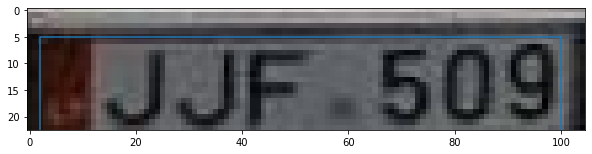

2021-07-08 15:18:02,123 [322426] WARNING  py.warnings:109: [JupyterRequire] /usr/local/lib64/python3.8/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "

2021-07-08 15:18:02,126 [322426] WARNING  py.warnings:109: [JupyterRequire] /usr/local/lib64/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "



output shape is (3, 300, 300) (300, 300, 2)
[[ 66. 284.]
 [ 66.   6.]
 [300.   6.]
 [300. 284.]]


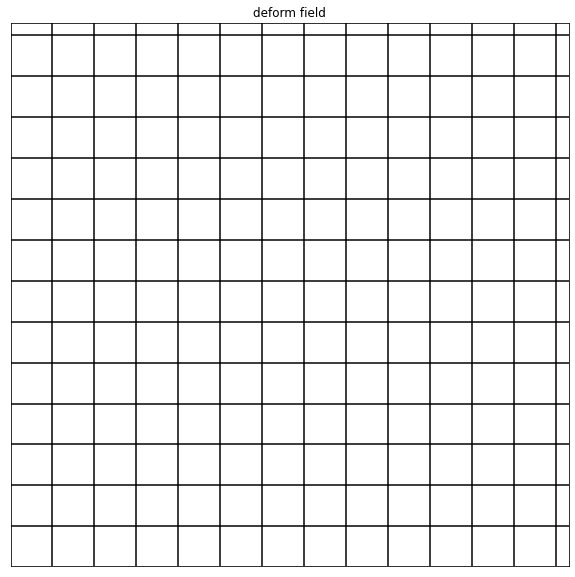

[[[-0.99666667 -0.99666667]
  [-0.99       -0.99666667]
  [-0.98333335 -0.99666667]
  ...
  [ 0.98333335 -0.99666667]
  [ 0.99       -0.99666667]
  [ 0.99666667 -0.99666667]]

 [[-0.99666667 -0.99      ]
  [-0.99       -0.99      ]
  [-0.98333335 -0.99      ]
  ...
  [ 0.98333335 -0.99      ]
  [ 0.99       -0.99      ]
  [ 0.99666667 -0.99      ]]

 [[-0.99666667 -0.98333335]
  [-0.99       -0.98333335]
  [-0.98333335 -0.98333335]
  ...
  [ 0.98333335 -0.98333335]
  [ 0.99       -0.98333335]
  [ 0.99666667 -0.98333335]]

 ...

 [[-0.99666667  0.98333335]
  [-0.99        0.98333335]
  [-0.98333335  0.98333335]
  ...
  [ 0.98333335  0.98333335]
  [ 0.99        0.98333335]
  [ 0.99666667  0.98333335]]

 [[-0.99666667  0.99      ]
  [-0.99        0.99      ]
  [-0.98333335  0.99      ]
  ...
  [ 0.98333335  0.99      ]
  [ 0.99        0.99      ]
  [ 0.99666667  0.99      ]]

 [[-0.99666667  0.99666667]
  [-0.99        0.99666667]
  [-0.98333335  0.99666667]
  ...
  [ 0.98333335  0.996666

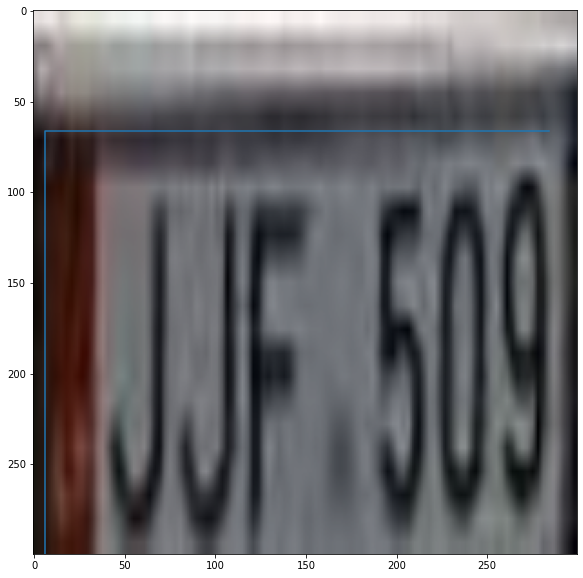

In [8]:
test_stn_net()

In [11]:
def train(batch_size=32):
    # get device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # init dataloader
    dm = STNetDataModule(batch_size=batch_size)
    
    # init model
    stn = STNet()
    stn.to(device)
    
    # most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
    # trainer = pl.Trainer(gpus=8) (if you have GPUs)
    trainer = pl.Trainer(max_epochs=100, gpus=1)
    trainer.fit(stn, dm)
    
    # save model
    torch.jit.save(stn.to_torchscript(), "spatial_transformer.pt")

In [12]:
train()

2021-07-08 15:18:14,821 [322426] WARNING  py.warnings:109: [JupyterRequire] /usr/local/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  rank_zero_warn(f'you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop')



Loading dataset...


FileNotFoundError: [Errno 2] No such file or directory: '../datasets/spatial_transformer_dataset/val/via_region_data_sorted.json'

In [24]:
@torch.no_grad()
def inference(img_path):
    # get device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # init model
    stn_torch_model = torch.load("spatial_transformer.pt")
    stn_torch_model.to(device)

    # read image
    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.show()

    #  normalize image
    x = normalize(img)
    x = torch.Tensor([x])
    x = x.to(device)

    # predict
    output_images, grids = stn_torch_model(x)
    output_images = output_images.cpu().numpy()
    grids = grids.cpu().numpy()

    # view res
    for output_image, grid in zip(output_images, grids):
        print('output shape is', output_image.shape, grid.shape)
        output_image = np.moveaxis(output_image, 0, -1)
        print(grid)
        grid2contour(grid)
        plt.imshow(output_image)
        plt.show()

/usr/local/lib64/python3.9/site-packages/torch/serialization.py:587: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


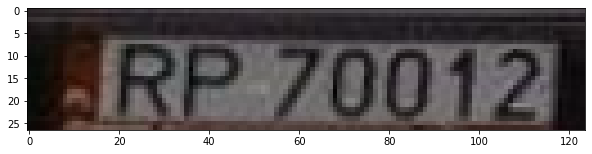

code/__torch__/torch/nn/functional.py:13: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
code/__torch__/torch/nn/functional.py:128: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.


output shape is (3, 300, 300) (300, 300, 2)
[[[-9.0704679e-02  2.9558849e-01]
  [-7.4792624e-02  2.9440212e-01]
  [-5.8880568e-02  2.9321575e-01]
  ...
  [ 4.6351662e+00 -5.6734085e-02]
  [ 4.6510782e+00 -5.7920456e-02]
  [ 4.6669903e+00 -5.9106827e-02]]

 [[-9.0461731e-02  3.2499170e-01]
  [-7.4549675e-02  3.2380533e-01]
  [-5.8637619e-02  3.2261944e-01]
  ...
  [ 4.6354094e+00 -2.7330875e-02]
  [ 4.6513214e+00 -2.8516769e-02]
  [ 4.6672335e+00 -2.9703140e-02]]

 [[-9.0218544e-02  3.5439539e-01]
  [-7.4306488e-02  3.5320902e-01]
  [-5.8394432e-02  3.5202265e-01]
  ...
  [ 4.6356525e+00  2.0728111e-03]
  [ 4.6515646e+00  8.8644028e-04]
  [ 4.6674767e+00 -2.9945374e-04]]

 ...

 [[-1.8486500e-02  9.0284519e+00]
  [-2.5744438e-03  9.0272655e+00]
  [ 1.3337612e-02  9.0260792e+00]
  ...
  [ 4.7073846e+00  8.6761303e+00]
  [ 4.7232966e+00  8.6749439e+00]
  [ 4.7392087e+00  8.6737576e+00]]

 [[-1.8243313e-02  9.0578556e+00]
  [-2.3312569e-03  9.0566692e+00]
  [ 1.3580799e-02  9.0554829e+00]


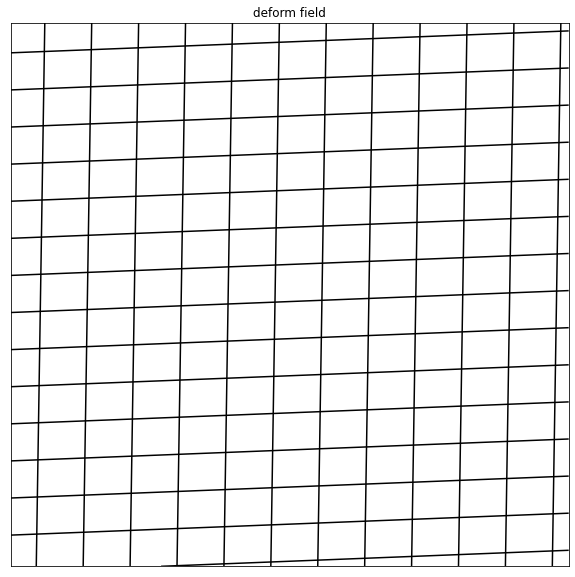

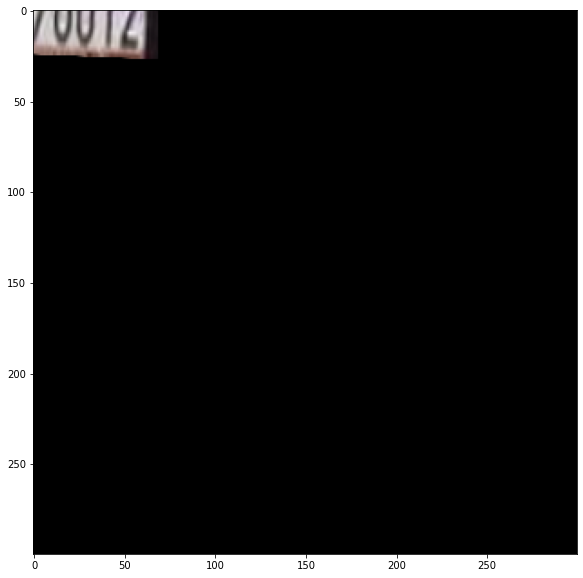

In [25]:
inference("../examples/crop_np_images/RP70012.png")

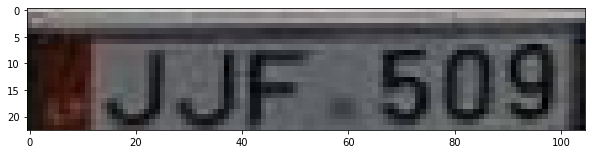

output shape is (3, 300, 300) (300, 300, 2)
[[[-0.13389659  0.21884489]
  [-0.11828375  0.21778536]
  [-0.10267067  0.2167263 ]
  ...
  [ 4.5031605  -0.09577942]
  [ 4.5187736  -0.09683847]
  [ 4.5343866  -0.09789801]]

 [[-0.13365555  0.24745321]
  [-0.11804271  0.24639368]
  [-0.10242963  0.24533415]
  ...
  [ 4.5034018  -0.0671711 ]
  [ 4.5190144  -0.06823063]
  [ 4.5346274  -0.06928968]]

 [[-0.13341475  0.27606106]
  [-0.1178019   0.275002  ]
  [-0.10218883  0.27394247]
  ...
  [ 4.503642   -0.03856277]
  [ 4.5192556  -0.03962231]
  [ 4.5348682  -0.04068184]]

 ...

 [[-0.06234884  8.715487  ]
  [-0.046736    8.714427  ]
  [-0.03112292  8.713367  ]
  ...
  [ 4.574708    8.400862  ]
  [ 4.5903215   8.399803  ]
  [ 4.605934    8.398744  ]]

 [[-0.06210804  8.744095  ]
  [-0.0464952   8.743035  ]
  [-0.03088212  8.741976  ]
  ...
  [ 4.5749493   8.42947   ]
  [ 4.590562    8.4284115 ]
  [ 4.606175    8.427351  ]]

 [[-0.061867    8.772703  ]
  [-0.04625416  8.771643  ]
  [-0.03064108

code/__torch__/torch/nn/functional.py:13: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
code/__torch__/torch/nn/functional.py:128: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.


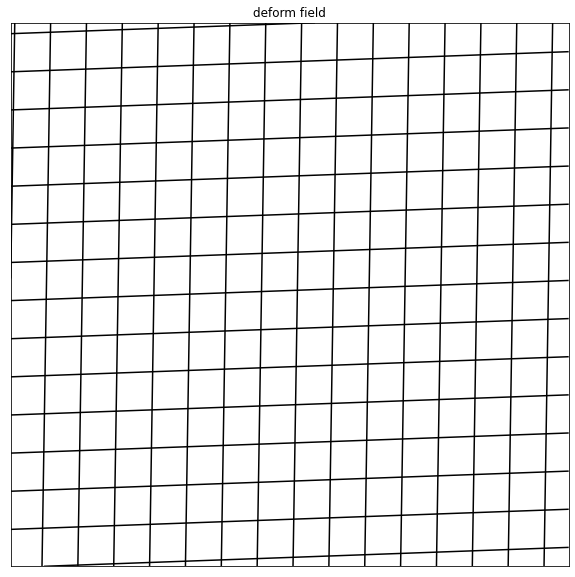

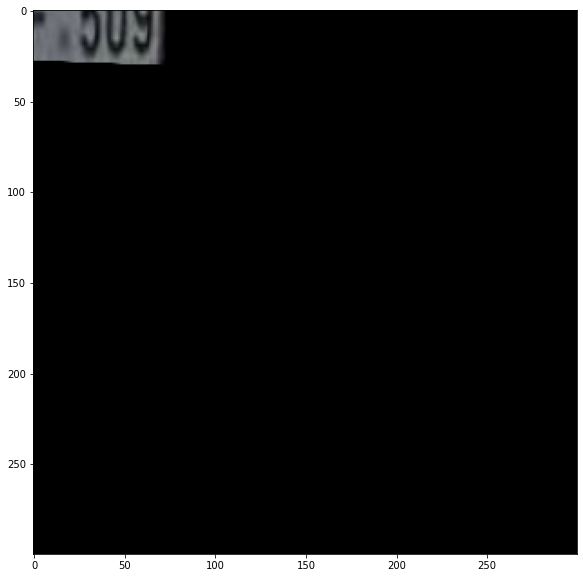

In [26]:
inference("../examples/crop_np_images/JJF509.png")